## How To Run:
Just Run all the cells below, make sure you have in hte same directory the ml-100k dataset

Harel Damari 305792020
Omer Lapidot

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers  import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda

import tensorflow as tf
from tensorflow import keras
from pprint import pprint
np.random.seed(31415)

In [2]:
users_cols = ['user id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
users.head()

,user id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [3]:
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
ratings_dataset["movie id"] = ratings_dataset["movie id"] - 1
ratings_dataset.head() 

,user id,movie id,rating,timestamp
0,196,241,3,881250949
1,186,301,3,891717742
2,22,376,1,878887116
3,244,50,2,880606923
4,166,345,1,886397596


In [4]:
ratings_dataset = pd.merge(ratings_dataset, users, how="left", on="user id")

In [5]:
features = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
column_names_str = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = column_names_str.split(' | ')

items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset["movie id"] = items_dataset["movie id"] - 1
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

,movie id,movie title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)


In [7]:
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,age,sex,occupation,zip_code,movie title
0,196,241,3,881250949,49,M,writer,55105,Kolya (1996)
1,63,241,3,875747190,31,M,marketing,75240,Kolya (1996)
2,226,241,5,883888671,28,M,student,92103,Kolya (1996)
3,154,241,3,879138235,25,M,student,53703,Kolya (1996)
4,306,241,5,876503793,45,M,other,73132,Kolya (1996)


<AxesSubplot: >

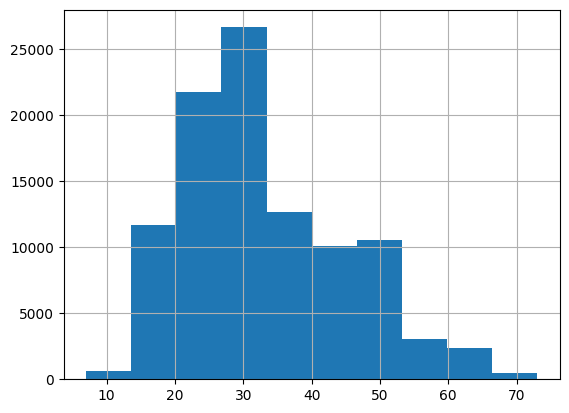

In [8]:
merged_dataset.age.hist()

In [9]:
merged_dataset.shape, merged_dataset.keys()

((100000, 9),
 Index(['user id', 'movie id', 'rating', 'timestamp', 'age', 'sex',
        'occupation', 'zip_code', 'movie title'],
       dtype='object'))

In [10]:
user_enc = LabelEncoder()
merged_dataset['user'] = user_enc.fit_transform(merged_dataset['user id'].values)
n_users = merged_dataset['user'].nunique()

In [11]:
item_enc = LabelEncoder()
merged_dataset['movie'] = item_enc.fit_transform(merged_dataset['movie title'].values)
n_movies = merged_dataset['movie'].nunique()

In [12]:
occupation_enc = LabelEncoder()
merged_dataset['occupation'] = occupation_enc.fit_transform(merged_dataset['occupation'].values)

In [13]:
sex_enc = LabelEncoder()
merged_dataset['sex'] = sex_enc.fit_transform(merged_dataset['sex'].values)

In [14]:
zip_code = LabelEncoder()
merged_dataset['zip_code'] = zip_code.fit_transform(merged_dataset['zip_code'].values)

In [15]:
merged_dataset['rating'] = merged_dataset['rating'].values.astype(np.float32)
min_age = min(merged_dataset['age'])
max_age = max(merged_dataset['age'])
n_users, n_movies, min_age, max_age

(943, 1664, 7, 73)

In [16]:
merged_dataset['age'] = (merged_dataset['age'] - min_age)/(max_age - min_age)

In [17]:
merged_dataset = merged_dataset.sort_values("timestamp").reset_index(drop=True)

### Dataset Timestamps

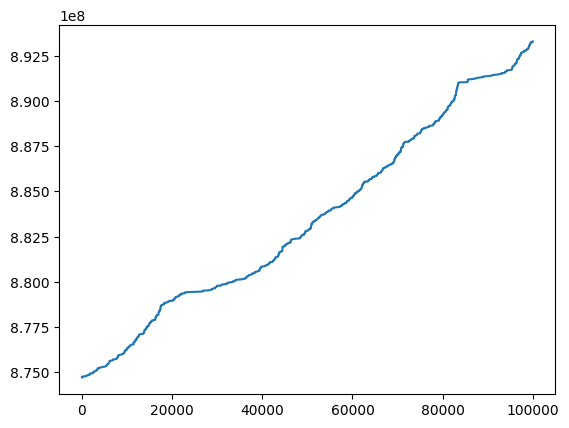

In [18]:
plt.plot(merged_dataset.timestamp.values)

### Build Dataset with window of 21 (20 movies as a start sequence and predict on the 21)

In [19]:
size = 500000
window_size = 21
X, y, ts, user_ids = [], [], [], []
for user_id, df in tqdm(merged_dataset.groupby("user")):
    for x in df.rolling(window_size):
        if x.shape[0] < window_size:
            continue
        movies_indices = x.iloc[:-1]["movie"].values.astype(int) # First window videos
        genres_mean = items_dataset[items_dataset["movie title"].isin(x.iloc[:-1]["movie title"])][features].mean(axis=0).values
        user_context = (x.iloc[0]['sex'].astype(int), x.iloc[0]['age'], x.iloc[0]['occupation'].astype(int), x.iloc[0]['zip_code'].astype(int))
        X.append([movies_indices, user_context, genres_mean]) 
        y.append(x.iloc[-1]["movie"]) # Next movie in window
        ts.append(x.iloc[-1]["timestamp"])
        user_ids.append(x.iloc[0]['user id'])
    if len(X) > size:
        break

100%|████████████████████████████████████████████████████████████████████████████████| 943/943 [03:34<00:00,  4.39it/s]


### Split to train and test (20% - test)

In [20]:
cut_idx = int(len(ts)*0.8)
cut_idx

64912

In [21]:
indices = np.arange(len(X))
train_indices = indices[:cut_idx]
test_indices = indices[cut_idx:]

In [22]:
x1 = np.stack(np.asarray(X, dtype=object)[:, 0])
x2 = np.stack(np.asarray(X, dtype=object)[:, 1])
x3 = np.stack(np.asarray(X, dtype=object)[:, 2])
y =  np.asarray(y)

In [23]:
X_train = [x1[train_indices], x2[train_indices], x3[train_indices]]
y_train = y[train_indices]

X_test = [x1[test_indices], x2[test_indices], x3[test_indices]]
y_test = y[test_indices]

In [24]:
X_train[0].shape

(64912, 20)

In [25]:
df = pd.DataFrame(user_ids, columns=["user_idx"])

In [26]:
df.loc[:cut_idx, "label"] = "red"
df.loc[cut_idx:, "label"] = "blue"

#### Train test split by the users RED=Train, BLUE=TEST

<AxesSubplot: xlabel='user_idx', ylabel='user_idx'>

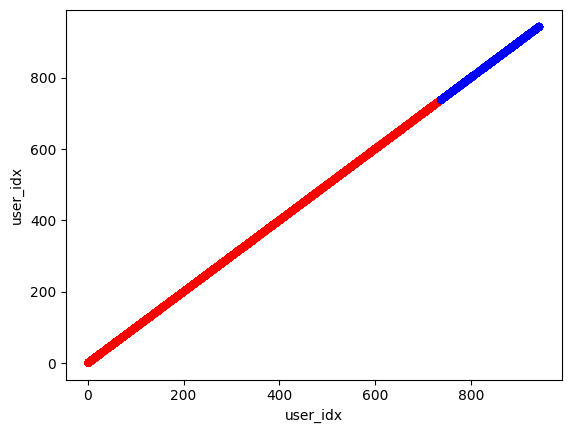

In [27]:
df.plot.scatter(x="user_idx", y="user_idx", c="label")

## Building a Deep Neural Network Youtube REcommender System

In [91]:
def make_paper_model(embedding_size, scale_factor):
    
    user_context = tf.keras.layers.Input(shape = (4,))
    movies_window = tf.keras.layers.Input(shape = (window_size-1,))
    genres = tf.keras.layers.Input(shape = (18,))
    inputs = [movies_window, user_context, genres]
    
    u = tf.keras.layers.Dense(64)(inputs[1])
        
    m = Embedding(n_movies, embedding_size)(inputs[0])
    m = tf.reduce_mean(m, axis=1)
    
    m = tf.keras.layers.Reshape((embedding_size,))(m)
    
    x = tf.keras.layers.Concatenate()([u, m])
    x = tf.keras.layers.Dense(1024*scale_factor)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(512*scale_factor)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(256*scale_factor)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    outputs = tf.keras.layers.Dense(n_movies, activation="softmax")(x)
    return keras.Model(inputs=inputs, outputs=outputs), "paper_model"


# model, _ = make_paper_model(150, scale_factor=2)
# model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [99]:
def make_imporved_model(embedding_size, scale_factor):
    
    user_context = tf.keras.layers.Input(shape = (4,))
    movies_window = tf.keras.layers.Input(shape = (window_size-1,))
    genres = tf.keras.layers.Input(shape = (18,))
    inputs = [movies_window, user_context, genres]
    
    u = tf.keras.layers.Dense(int(16*scale_factor))(user_context)
    v = tf.keras.layers.Dense(int(16*scale_factor))(genres)

    m = Embedding(n_movies, embedding_size)(inputs[0])
    m = tf.reduce_mean(m, axis=1)
    
    x = tf.keras.layers.Concatenate()([u, v, movies_window])
    x = tf.einsum('ki,kj->kij',x,x)
    x = tf.expand_dims(x, -1)

    x = tf.keras.layers.Conv2D(filters=int(16*scale_factor), kernel_size=(3,3), activation="relu")(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    x = tf.keras.layers.Conv2D(filters=int(32*scale_factor), kernel_size=(3,3), activation="relu")(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Concatenate()([m, x]) 
    
    x = tf.keras.layers.Dense(int(64*scale_factor), activation="relu")(x)
    x = tf.keras.layers.Dense(int(128*scale_factor), activation="relu")(x)
    x = tf.keras.layers.Dense(int(256*scale_factor), activation="relu")(x)
    outputs = tf.keras.layers.Dense(n_movies, activation="softmax")(x)
    return keras.Model(inputs=inputs, outputs=outputs), "improved_model"

# model, _ = make_imporved_model(150, scale_factor=1)
# model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#### Grid search:

In [30]:
import functools
top5_acc = functools.partial(keras.metrics.sparse_top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'
top10_acc = functools.partial(keras.metrics.sparse_top_k_categorical_accuracy, k=10)
top10_acc.__name__ = 'top10_acc'

### Train or not to Train?

In [31]:
train = True

#### Grid search parameters

In [32]:
optimizers = [lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
              lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
              lambda: tf.keras.optimizers.SGD()]
losses = [lambda: tf.keras.losses.SparseCategoricalCrossentropy()]
embeddings_sizes = [16, 32, 64, 128]
scale_factors = [0.5, 1, 2, 4, 8]

Epoch 1/20
508/508 [==============================] - 21s 38ms/step - loss: 7.0766 - top5_acc: 0.0138 - top10_acc: 0.0273 - val_loss: 6.7377 - val_top5_acc: 0.0179 - val_top10_acc: 0.0360
Epoch 2/20
508/508 [==============================] - 18s 36ms/step - loss: 6.7463 - top5_acc: 0.0172 - top10_acc: 0.0335 - val_loss: 6.6415 - val_top5_acc: 0.0209 - val_top10_acc: 0.0418
Epoch 3/20
508/508 [==============================] - 18s 36ms/step - loss: 6.6729 - top5_acc: 0.0219 - top10_acc: 0.0415 - val_loss: 6.5622 - val_top5_acc: 0.0270 - val_top10_acc: 0.0516
Epoch 4/20
508/508 [==============================] - 17s 34ms/step - loss: 6.5753 - top5_acc: 0.0265 - top10_acc: 0.0507 - val_loss: 6.4919 - val_top5_acc: 0.0317 - val_top10_acc: 0.0596
Epoch 5/20
508/508 [==============================] - 18s 35ms/step - loss: 6.5184 - top5_acc: 0.0290 - top10_acc: 0.0550 - val_loss: 6.4527 - val_top5_acc: 0.0302 - val_top10_acc: 0.0590
Epoch 6/20
508/508 [==============================] - 17s 34

C:\Users\harel\AppData\Local\Temp\ipykernel_8728\1004284324.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


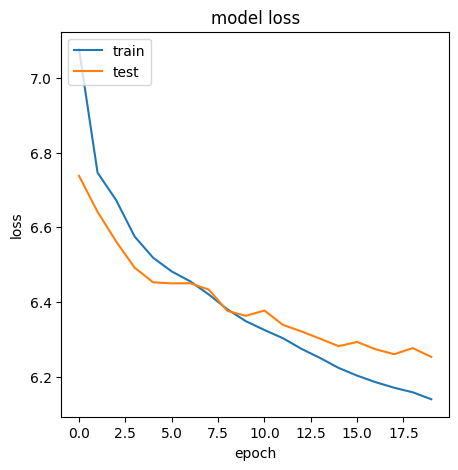

In [89]:
optimizers = [lambda: tf.keras.optimizers.Adam(learning_rate=0.001)]
losses = [lambda: tf.keras.losses.SparseCategoricalCrossentropy()]
embeddings_sizes = [64]
scale_factors = [1]

histories = {}
# df = pd.read_csv("paper_gs_1.csv", index_col=0)

for scale_factor in scale_factors:
    for e_size in embeddings_sizes:
        for optimizer_lambda in optimizers:
            for loss_lambda in losses:
                if not train:
                    continue
                model, _ = make_paper_model(e_size, scale_factor)
                
                optimizer= optimizer_lambda()
                loss = loss_lambda()

                model.compile(optimizer=optimizer, loss=loss, metrics=[top5_acc, top10_acc])
                # reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=0)
                history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, y_test) ,shuffle=True) #,callbacks=[reduce_lr])

                histories[(str(scale_factor), str(e_size), str(optimizer), str(loss))] = history

                row = {"embedding": str(e_size),
                       "optimizer": str(optimizer),
                       "loss_func": str(loss),
                       "scale_factor": scale_factor,
                       "optimizer_lr": optimizer.get_config().get("learning_rate")
                      }
                row.update({k:v[-1] for k, v in history.history.items()})

                df = df.append(row, ignore_index=True)
                # df.to_csv("paper_gs_1.csv")
                
                print(scale_factor, e_size, optimizer, loss)
                plt.figure(figsize=(5,5))
                plt.plot(history.history["loss"])
                plt.plot(history.history["val_loss"])
                plt.title("model loss")
                plt.ylabel("loss")
                plt.xlabel("epoch")
                plt.legend(["train", "test"], loc="upper left")
                plt.show()
# df.to_csv("paper_gs_1.csv")

Epoch 1/7
508/508 [==============================] - 86s 167ms/step - loss: 831.7107 - top5_acc: 0.0369 - top10_acc: 0.0627 - val_loss: 6.2836 - val_top5_acc: 0.0404 - val_top10_acc: 0.0741
Epoch 2/7
508/508 [==============================] - 99s 194ms/step - loss: 6.1684 - top5_acc: 0.0408 - top10_acc: 0.0783 - val_loss: 6.2227 - val_top5_acc: 0.0449 - val_top10_acc: 0.0813
Epoch 3/7
508/508 [==============================] - 81s 159ms/step - loss: 6.0549 - top5_acc: 0.0457 - top10_acc: 0.0859 - val_loss: 6.2218 - val_top5_acc: 0.0446 - val_top10_acc: 0.0813
Epoch 4/7
508/508 [==============================] - 77s 152ms/step - loss: 5.9868 - top5_acc: 0.0497 - top10_acc: 0.0926 - val_loss: 6.2176 - val_top5_acc: 0.0450 - val_top10_acc: 0.0844
Epoch 5/7
508/508 [==============================] - 77s 152ms/step - loss: 5.9340 - top5_acc: 0.0527 - top10_acc: 0.0970 - val_loss: 6.2631 - val_top5_acc: 0.0478 - val_top10_acc: 0.0882
Epoch 6/7
508/508 [==============================] - 81s 1

C:\Users\harel\AppData\Local\Temp\ipykernel_8728\1697666195.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


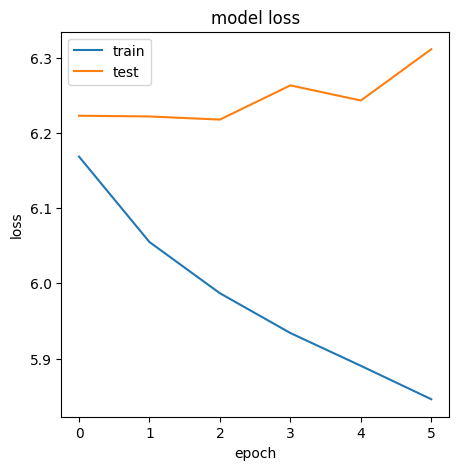

In [102]:
optimizers = [lambda: tf.keras.optimizers.Adam(learning_rate=0.01)]
losses = [lambda: tf.keras.losses.SparseCategoricalCrossentropy()]
embeddings_sizes = [128]
scale_factors = [1]


histories = {}
df = pd.read_csv("improved_gs_1.csv", index_col=0)

for scale_factor in scale_factors:
    for e_size in embeddings_sizes:
        for optimizer_lambda in optimizers:
            for loss_lambda in losses:
                if not train:
                    continue
                model, _ = make_imporved_model(e_size, scale_factor)
                
                optimizer= optimizer_lambda()
                loss = loss_lambda()

                model.compile(optimizer=optimizer, loss=loss, metrics=[top5_acc, top10_acc])
                # reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=0)
                history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=7, verbose=1, validation_data=(X_test, y_test) ,shuffle=True, ) #,callbacks=[reduce_lr])

                histories[(str(scale_factor), str(e_size), str(optimizer), str(loss))] = history

                row = {"embedding": str(e_size),
                       "optimizer": str(optimizer),
                       "loss_func": str(loss),
                       "scale_factor": scale_factor,
                       "optimizer_lr": optimizer.get_config().get("learning_rate")
                      }
                row.update({k:v[-1] for k, v in history.history.items()})

                df = df.append(row, ignore_index=True)
                # df.to_csv("improved_gs_1.csv")
                print(scale_factor, e_size, optimizer, loss)
                plt.figure(figsize=(5,5))
                plt.plot(history.history["loss"][1:])
                plt.plot(history.history["val_loss"][1:])
                plt.title("model loss")
                plt.ylabel("loss")
                plt.xlabel("epoch")
                plt.legend(["train", "test"], loc="upper left")
                plt.show()
# df.to_csv("improved_gs_1.csv")

## Getting movies for given User

In [110]:
merged_dataset.head()

,user id,movie id,rating,timestamp,age,sex,occupation,zip_code,movie title,user,movie
0,259,254,4.0,874724710,0.212121,1,18,367,My Best Friend's Wedding (1997),258,1025
1,259,285,4.0,874724727,0.212121,1,18,367,"English Patient, The (1996)",258,460
2,259,297,4.0,874724754,0.212121,1,18,367,Face/Off (1997),258,484
3,259,184,4.0,874724781,0.212121,1,18,367,Psycho (1960),258,1189
4,259,172,4.0,874724843,0.212121,1,18,367,"Princess Bride, The (1987)",258,1178


In [111]:

user_id = [777]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(merged_dataset[merged_dataset['user id'] == user_id[0]]['movie'])
print(seen_movies)

[460, 1302, 1284, 411, 1251, 389, 498, 1523, 783, 666, 1157, 399, 337, 1102, 87, 1005, 390, 1132, 580, 1342, 1558, 7, 612, 1032, 996, 1208, 528, 1615, 604, 432, 643, 1190, 113, 313, 55, 1260]


Id's of movies which are already seen by the user are extracted.

In [112]:
len(merged_dataset['movie'].unique()), min(merged_dataset['movie']), max(merged_dataset['movie'])

(1664, 0, 1663)

We can understand that the labels are from 0 to 1663. So the movie id's which are not seen by the user can be pciked just by excluding the 'seen_movies' list from the first 1663 natural numbers.

#### Example Predictions

In [113]:
X_test

[array([[1386,  431,  571, ..., 1013,  465,  134],
        [ 431,  571, 1481, ...,  465,  134,  570],
        [ 571, 1481, 1373, ...,  134,  570,  711],
        ...,
        [ 134, 1069, 1048, ..., 1392, 1396, 1397],
        [1069, 1048,  208, ..., 1396, 1397, 1390],
        [1048,  208, 1362, ..., 1397, 1390, 1391]]),
 array([[1.00000000e+00, 4.24242424e-01, 1.90000000e+01, 7.22000000e+02],
        [1.00000000e+00, 4.24242424e-01, 1.90000000e+01, 7.22000000e+02],
        [1.00000000e+00, 4.24242424e-01, 1.90000000e+01, 7.22000000e+02],
        ...,
        [1.00000000e+00, 2.27272727e-01, 1.80000000e+01, 5.61000000e+02],
        [1.00000000e+00, 2.27272727e-01, 1.80000000e+01, 5.61000000e+02],
        [1.00000000e+00, 2.27272727e-01, 1.80000000e+01, 5.61000000e+02]]),
 array([[0.65, 0.3 , 0.  , ..., 0.35, 0.1 , 0.05],
        [0.7 , 0.25, 0.  , ..., 0.4 , 0.1 , 0.05],
        [0.7 , 0.25, 0.  , ..., 0.4 , 0.1 , 0.05],
        ...,
        [0.5 , 0.35, 0.  , ..., 0.05, 0.  , 0.1 ],
   

In [114]:
preds = model.predict(X_test)

508/508 [==============================] - 7s 14ms/step


In [115]:
idx = 1

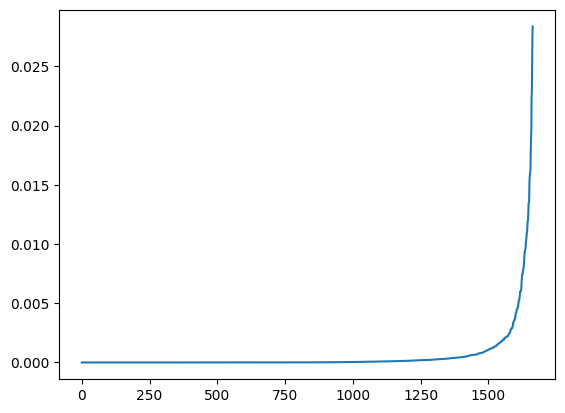

In [116]:
plt.plot(sorted(preds[idx]))

In [117]:
user = X_test[1][idx]
movies = X_test[0][idx]

In [118]:
movies

array([ 431,  571, 1481, 1373, 1329,  768, 1513, 1410, 1516,  884,  945,
         97,  792, 1251, 1394,   88, 1013,  465,  134,  570])

In [119]:
movies_titles = item_enc.inverse_transform(movies)
pprint(movies_titles)

array(['Down Periscope (1996)', 'Full Metal Jacket (1987)',
       'This Is Spinal Tap (1984)', 'Speed (1994)',
       'Silence of the Lambs, The (1991)',
       "Jackie Chan's First Strike (1996)", 'Tombstone (1993)',
       'Strange Days (1995)', 'Top Gun (1986)',
       'Long Kiss Goodnight, The (1996)', 'Mars Attacks! (1996)',
       'Arsenic and Old Lace (1944)', 'Jumanji (1995)',
       'Rock, The (1996)', 'Star Trek: First Contact (1996)',
       'Apollo 13 (1995)', 'Mrs. Doubtfire (1993)',
       'Escape from New York (1981)', 'Batman Returns (1992)',
       'Fugitive, The (1993)'], dtype=object)


In [120]:
items_dataset.keys()

Index(['movie id', 'movie title', 'release date', 'video release date',
       'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

<AxesSubplot: >

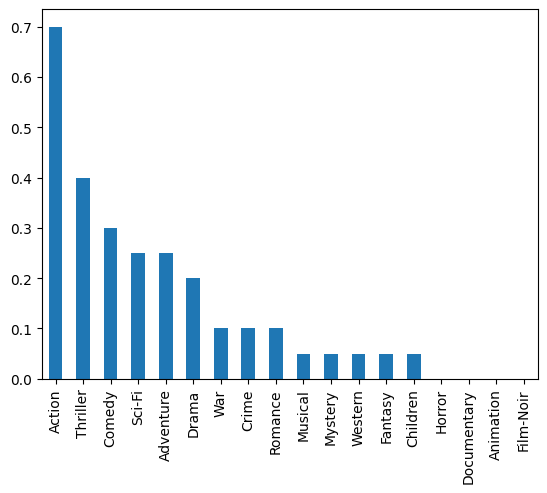

In [121]:
items_dataset[items_dataset["movie title"].isin(movies_titles)][features].mean(axis=0).sort_values(ascending=False).plot.bar()

In [122]:
pred_top_n = pd.DataFrame(preds[idx], columns=["score"]).nlargest(5, columns=["score"]).index
pred_top_n

Int64Index([1390, 1547, 1559, 415, 127], dtype='int64')

In [123]:
movies_titles = item_enc.inverse_transform(pred_top_n)
movies_titles

array(['Star Trek III: The Search for Spock (1984)', 'Twister (1996)',
       'Under Siege (1992)', 'Die Hard 2 (1990)', 'Basic Instinct (1992)'],
      dtype=object)

#### Amazing!

<AxesSubplot: >

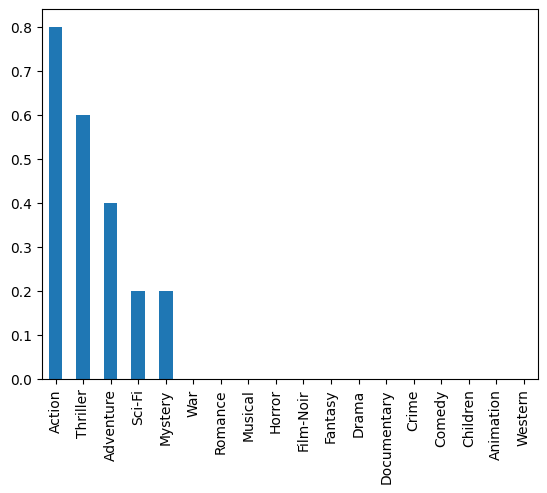

In [124]:
items_dataset[items_dataset["movie title"].isin(movies_titles)][features].mean(axis=0).sort_values(ascending=False).plot.bar()

#### Compare to benchmark (Collaborative filtering)

In [80]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [81]:
merged_dataset_bm = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

merged_dataset_bm.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


In [82]:
user_to_movie_df = merged_dataset_bm.pivot(
    index='user id',
     columns='movie title',
      values='rating').fillna(0)

user_to_movie_df.head()

movie title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [83]:
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<943x1664 sparse matrix of type '<class 'numpy.float32'>'
	with 99693 stored elements in Compressed Sparse Row format>

In [84]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [85]:
from pprint import pprint

def collaborative_recommender_system(user_id, n_similar_users, n_movies, target): #, user_to_movie_df, knn_model):
    def get_similar_users(user, n = 5):
        knn_input = np.asarray([user_to_movie_df.values[user-1]])
        distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
        return indices.flatten()[1:] + 1, distances.flatten()[1:]


    def filtered_movie_recommendations(n = 10):
        first_zero_index = np.where(mean_rating_list == 0)[0][-1]
        sortd_index = np.argsort(mean_rating_list)[::-1]
        sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
        n = min(len(sortd_index),n)
        movies_watched = list(merged_dataset_bm[merged_dataset_bm['user id'] == user_id]['movie title'])
        filtered_movie_list = list(movies_list[sortd_index])
        count = 0
        final_movie_list = []
        for i in filtered_movie_list:
            # print(i, target)
            if i == target:
                return True
            if i not in movies_watched or i == target:
                count+=1
                final_movie_list.append(i)
            if count == n:
                break
        if count == 0:
            print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
        else:
            pass        
        return False

    similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
    weightage_list = distance_list/np.sum(distance_list)
    mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
    movies_list = user_to_movie_df.columns
    weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
    new_rating_matrix = weightage_list*mov_rtngs_sim_users
    mean_rating_list = new_rating_matrix.sum(axis =0)
    return filtered_movie_recommendations(n_movies)

In [86]:
total_count = 0
top_10_count = 0
for example_idx in tqdm(list(range(cut_idx, len(y)))):
    total_count += 1
    target = item_enc.inverse_transform([y[example_idx]])[0]
    movies_titles = item_enc.inverse_transform(x1[example_idx])
    results = collaborative_recommender_system(user_ids[example_idx], 5,10, target=target)
    if results:
        top_10_count += 1 

100%|███████████████████████████████████████████████████████████████████████████| 16228/16228 [00:46<00:00, 350.42it/s]


In [87]:
top_10_count/total_count

0.05656889327088982